In [22]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from PIL import Image

In [23]:
model = tf.keras.models.load_model('fog_classifier_1209_epoch_500.h5')

In [24]:
# test_Fog_Image = 'fog_test.png'

fog_image = 'data/Fog_test_image.png'

test_Fog_Image = fog_image

# load a single image for testing
test_image = tf.keras.preprocessing.image.load_img(test_Fog_Image, target_size = (150, 150))
# test_image = tf.keras.preprocessing.image.load_img('No_fog_test.jpg', target_size = (150, 150))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

# predict the result
result = model.predict(test_image)

# assuming that the class indices are {0: 'no_fog', 1: 'fog'}
if result[0][0] == 1:
    prediction = '안개 없음'
else:
    prediction = '안개 있음'

print(prediction)


1/1 [==============================] - 0s 52ms/step
안개 없음


Phase I - Normal


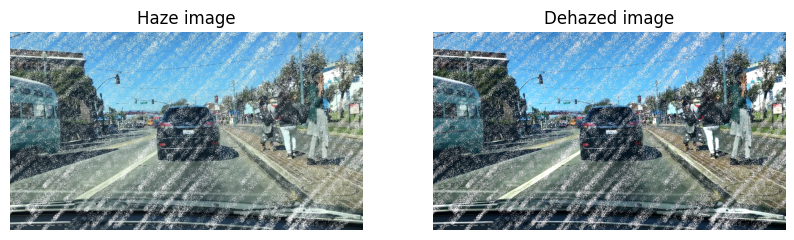

In [25]:
"""
Fast Single Image Dehazing Using Saturation Based Transmission Map Estimation

Original source
https://sites.google.com/view/ispl-pnu/software#h.y6sdafma686

Modified by Wonvin Kim, 09/04/22
"""


import math
import numpy as np
from os import path as ospath

import cv2                     # pip install opencv-python
from skimage import morphology # pip install scikit-image

BINS = 256
MAX_LEVEL = BINS - 1

# 정규화 (0~1 사이로)
def i2f(img):
    return img / MAX_LEVEL

def f2i(img):
    return np.uint8(np.around(img * MAX_LEVEL))


# Compute 'A' as described by Tang et al. (CVPR 2014)
def compute_A_Tang(img):
    h, w = img.shape[:2] 

    dark_channel = morphology.erosion(np.min(img, 2), morphology.square(15)) 
    H, edges = np.histogram(dark_channel, 200)
    CDF = np.cumsum(H)
    idx = np.nonzero(CDF > h * w * 0.99)[0][0]
    threshold = edges[idx]
    mask = dark_channel >= threshold

    A = np.zeros(3)
    b, g, r = cv2.split(img)
    A[2] = np.median(r[mask])
    A[1] = np.median(g[mask])
    A[0] = np.median(b[mask])

    return A


# White balance using gray world assumption
def gray_world(img):
    b, g, r = cv2.split(img)

    R = np.empty(img.shape, img.dtype) 

    mu_r = np.average(r)
    mu_g = np.average(g)
    mu_b = np.average(b)
    
    R[..., 0] = np.minimum(b * (mu_g / mu_b), 1.0)
    R[..., 2] = np.minimum(r * (mu_g / mu_r), 1.0)
    R[..., 1] = g
 
    return  R

def normalize(img):
    R = np.empty(img.shape, img.dtype) 

    for i in range(3):
        min = img[..., i].min()
        max = img[..., i].max()
        R[..., i] = (img[..., i] - min) / (max - min)
        R[..., i] = np.clip(R[..., i], 0.0, 1.0)     
        
    return R

def get_value(img):
    return np.average(img, 2)

def get_saturation(img):
    return 1.0 - np.min(img, 2) / (np.average(img, 2) + np.finfo(np.float32).eps)


# Estimate saturation of scene radiance: 3 methods   
def estimate_saturation(saturation, p1):
    p2 = 2.0
    k1 = 0.5 *(1.0 - cv2.pow(1.0 - 2.0 * saturation, p1))
    k2 = 0.5 + 0.5 * cv2.pow((saturation - 0.5) / 0.5, p2)
    R = np.where(saturation <= 0.5, k1, k2)
    return np.maximum(R, saturation)

def estimate_saturation_quadratic(saturation):
    return saturation * (2.0 - saturation)

def estimate_saturation_gamma(saturation, gamma):
    R = (np.power(saturation, 1.0 / gamma) + 1.0 - np.power(1.0 - saturation, 1.0 / gamma)) / 2.0
    return np.maximum(R, saturation)

def estimate_TransimissionMap(value, i_saturation, j_saturation):
    R = 1.0 - value * (j_saturation - i_saturation) / j_saturation
    return np.clip(R, np.finfo(np.float32).eps, 1.0)

# map: transmission map, A: atmospheric light
def recover(img, map, A):
    J = np.empty(img.shape, img.dtype) 
    
    for i in range(3):
        J[..., i] = (img[..., i] - A[i]) / map + A[i]
        J[..., i] = np.clip(J[..., i], 0.0, 1.0)
   
    return J

def adjust(img, percentile_low, percentile_high):
    R = np.empty(img.shape, img.dtype)

    low = np.percentile(img, percentile_low)
    high = np.percentile(img, percentile_high)

    for i in range(3):
        R[..., i] = (img[..., i] - low) / (high - low)
        R[..., i] = np.clip(R[..., i], 0.0, 1.0)
        
    return R

def clahe(img, clip):
  HSV = cv2.cvtColor(f2i(img), cv2.COLOR_BGR2HSV)
  clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
  HSV[..., 2] = clahe.apply(HSV[..., 2])
  return i2f(cv2.cvtColor(HSV, cv2.COLOR_HSV2BGR))


# Saturation Based Transmission Map Estimation
def SBTE(img, is_only_result=True):
    I = i2f(img)
    A = compute_A_Tang(I)

    # Compute white balanced A
    I_WB = gray_world(I)
    A_WB = compute_A_Tang(I_WB)

    '''
    Parameter set
    - parameters for adjust: PER_LOW = 0.5, PER_HIGH = 99.9 (PER: percentile)
    - parameters for selecting two branch: EPSILON = (0.0, 0.1)
    - parameters for clahe: CLIP = 1 (0, 2)
    '''
    PER_HIGH = 99.9
    PER_LOW = 0.5
    EPSILON = 0.02
    CLIP = 1
    
    # Phase I - Normal
    if np.max(A) - np.min(A) < np.max(A_WB) - np.min(A_WB) + EPSILON:
        print('Phase I - Normal')
        phase = 1

    # Phase II - White Balance
    else: 
        print('Phase II - White Balance')
        phase = 2
        A = A_WB
        
    out = np.empty(I.shape, I.dtype) 
    for i in range(3):
        out[..., i] = I[..., i] / A[i]
    
    out = normalize(out)
    value = get_value(out)
    i_saturation = get_saturation(out)

    # j_saturation = estimate_saturation(i_saturation, 2.0)
    # j_saturation = estimate_saturation_quadratic(i_saturation)
    j_saturation = estimate_saturation_gamma(i_saturation, 0.2)

    transmission_map = estimate_TransimissionMap(value, i_saturation, j_saturation)
    J = recover(I, transmission_map, A)
    J = adjust(J, PER_LOW, PER_HIGH)
    if phase == 2: J = gray_world(J)
        
    J_enhanced = clahe(J, CLIP)
    J_enhanced = f2i(J_enhanced)
    J = f2i(J)

    return J if is_only_result else (J, J_enhanced, f2i(transmission_map))

import matplotlib.pyplot as plt

if __name__ == "__main__":
    DIR = 'outputs'

    O_PATH = ospath.join(DIR, 'stbe.jpg')
    I_PATH = ospath.join(fog_image)  # 안개 제거할 이미지 입력

    I = cv2.imread(I_PATH)
    J, J_enhanced, transmission_map = SBTE(I, is_only_result=False)

    cv2.imwrite(O_PATH, J)

    # 이미지를 화면에 출력
    plt.figure(figsize=(10, 5))  # 출력할 그래프의 크기를 설정
    plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 위치에 그래프 생성
    plt.title('Haze image')  # 그래프의 제목 설정
    plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))  # 이미지를 RGB 형식으로 변환하여 출력
    plt.axis('off')  # 축을 보이지 않게 설정

    plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치에 그래프 생성
    plt.title('Dehazed image')  # 그래프의 제목 설정
    plt.imshow(cv2.cvtColor(J, cv2.COLOR_BGR2RGB))  # 이미지를 RGB 형식으로 변환하여 출력
    plt.axis('off')  # 축을 보이지 않게 설정

    plt.show()  # 그래프를 화면에 출력

    cv2.imwrite(ospath.join(DIR, 'transmission map (SBTE).jpg'), transmission_map)
    cv2.imwrite(ospath.join(DIR, 'enhanced J (SBTE).jpg'), J_enhanced)

    # Dehazed 이미지를 저장
    DEHAZED_IMAGE_PATH = ospath.join('data', 'dehazed_image.jpg')  # 저장할 경로 설정
    cv2.imwrite(DEHAZED_IMAGE_PATH, J)  # Dehazed 이미지 파일로 저장




In [26]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import utils as sk_utils
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

from IPython.display import clear_output
clear_output()
print(tf.__version__)

2.14.0


In [27]:
from tensorflow.keras.models import load_model

# 모델 파일 경로를 지정합니다.
model = tf.keras.models.load_model('asad_epoch5.h5')

In [28]:
# 유틸리티 함수들

import numpy as np
import matplotlib.pyplot as plt

# 각 클래스에 대한 색상을 정의하는 딕셔너리
color_dict = {
    0: (0.7, 0.7, 0.7),     # 도로 - 회색
    1:  (0.9, 0.9, 0.2),     # 보도 - 연한 노랑
    2: (1.0, 0.4980392156862745, 0.054901960784313725),
    3: (1.0, 0.7333333333333333, 0.47058823529411764),
    4: (0.8, 0.5, 0.1),  # 울타리 - 녹슨 오렌지
    5: (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
    6: (0.325, 0.196, 0.361),
    7: (1.0, 0.596078431372549, 0.5882352941176471),
    8:  (0.2, 0.6, 0.2),     # 식물 - 녹색
    9: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
    10: (0.5, 0.7, 1.0),     # 하늘 - 연한 파랑
    11: (1.0, 0.0, 0.0), # 사람 - 빨강
    12: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    13: (0.0, 0.0, 1.0),  # 차 - 파랑
    14: (0.0, 0.0, 1.0),  # 트랙 - 파랑
    15: (0.0, 0.0, 1.0),  # 버스 - 파랑
    16: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
    17: (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
    18: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    19: (0, 0, 0) # 알 수 없음 - 검정
}

# 이미지를 색상화하는 함수
def colorize_image(image, color_dict):
    # 불필요한 차원 제거
    image = np.squeeze(image)
    # 색상 딕셔너리를 사용하여 색상화된 이미지 생성
    colored_image = np.zeros((image.shape[0], image.shape[1], 3))

    # 각 픽셀 값에 대해 색상 딕셔너리에서 색상을 찾아 이미지에 적용
    for pixel_value, color in color_dict.items():
        colored_image[image == pixel_value] = color

    # 이미지를 8비트 부호 없는 정수로 변환
    colored_image = (colored_image * 255).astype(np.uint8)

    return colored_image


In [29]:
import glob
image_size = (192, 256)

# 이미지를 불러오고 전처리하는 함수
def load_image(file_path, is_x=False):
    # tf.io.read_file을 사용하여 이미지 파일을 읽음
    image = tf.io.read_file(file_path)
    # 이미지를 텐서로 디코드함
    image = tf.image.decode_image(image)
    
    if is_x:
        # tf.image.resize를 사용하여 원하는 크기로 이미지를 리사이즈함. 여기서는 Lanczos3 메소드를 사용
        image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.LANCZOS3)
        image = image / 255.0  # 이미지를 정규화함(0~1 사이의 값으로 변환)
    else:
        # 'nearest' 메소드를 사용하여 원하는 크기로 이미지를 리사이즈함. 이때는 antialias=True 옵션을 사용
        image = tf.image.resize(image, image_size, method='nearest', antialias=True)
    return image


1/1 [==============================] - 0s 227ms/step


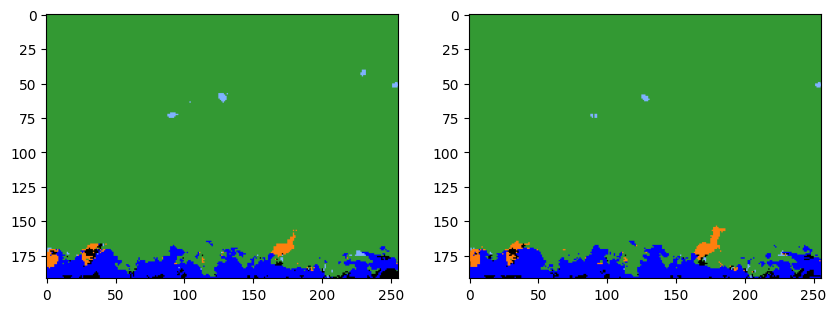

In [30]:
# 불러올 이미지 파일 경로를 리스트로 지정합니다.
image_paths = ["data/dehazed_image.jpg", "data/qwer.jpg"]

# 새로운 그림을 생성합니다.
plt.figure(figsize=(10, 5))  # figsize를 조절하여 그림의 크기를 변경할 수 있습니다.

for i, image_path in enumerate(image_paths):  # 각 이미지 경로에 대해
    # 이미지 파일을 로드하고 전처리합니다.
    image = tf.io.read_file(image_path)  # 이미지 파일을 읽습니다.
    image = tf.image.decode_image(image)  # 이미지를 텐서로 디코드합니다.
    image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.LANCZOS3)  # 이미지를 원하는 크기로 리사이즈합니다.
    image = image / 255.0  # 이미지를 정규화합니다.

    # 이미지에 차원을 추가하여 모델의 입력 형태에 맞게 만듭니다.
    image = np.expand_dims(image, axis=0)

    # 이미지를 모델에 전달하여 예측 마스크를 생성합니다.
    pred_mask = model.predict(image)

    # 예측된 마스크에서 가장 확률이 높은 클래스를 선택합니다.
    pred_mask = np.argmax(pred_mask, axis=-1)

    # 예측 마스크를 시각화하기 위해 색상화 함수를 사용합니다.
    colored_mask = colorize_image(pred_mask[0], color_dict)  # 첫 번째(그리고 유일한) 예측 마스크를 색상화합니다.

    # 예측 마스크를 서브플롯으로 시각화합니다.
    plt.subplot(1, len(image_paths), i+1)  # 1행에 len(image_paths)개의 서브플롯을 생성합니다.
    plt.imshow(colored_mask)

plt.show()  # 모든 서브플롯을 한 번에 출력합니다.


1/1 [==============================] - 0s 229ms/step


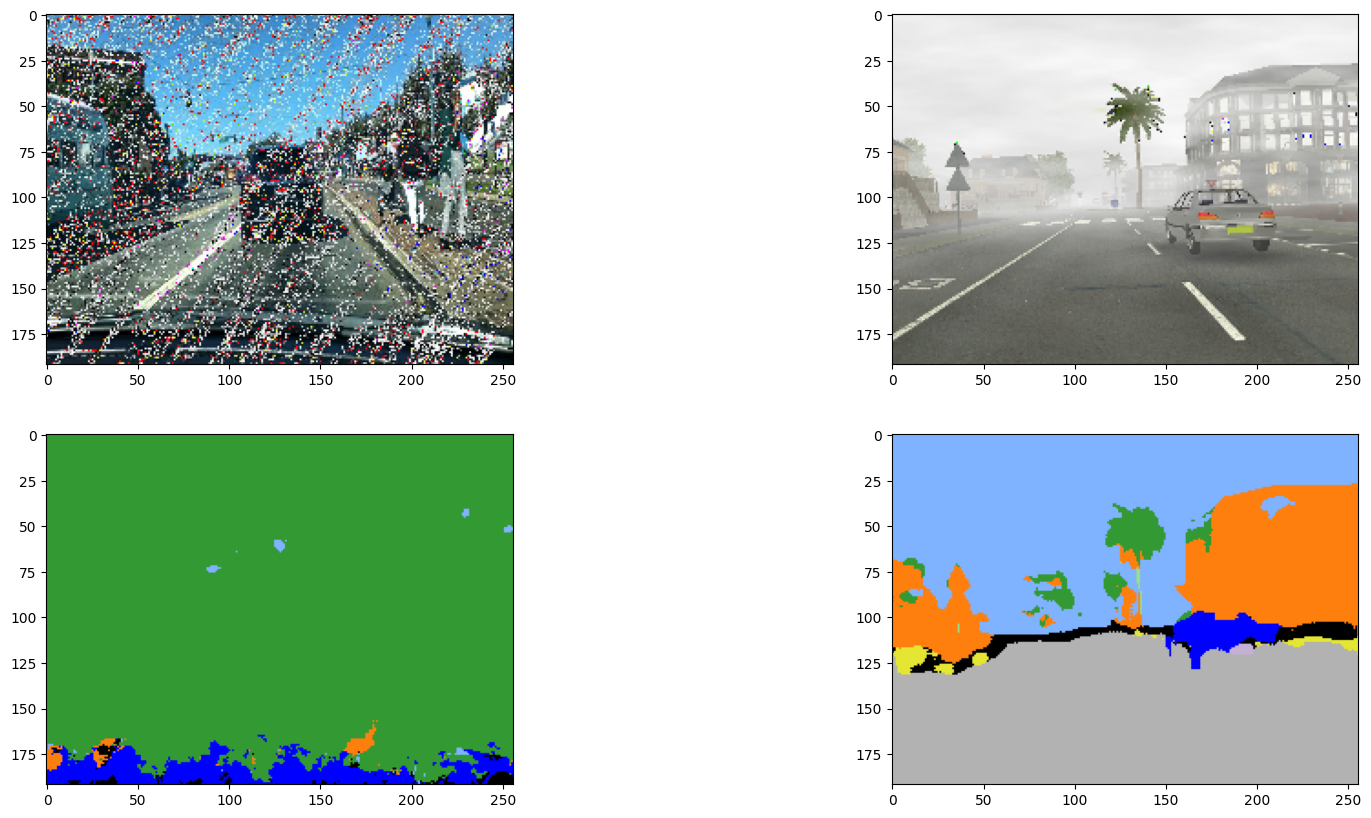

In [31]:
# 불러올 이미지 파일 경로를 리스트로 지정합니다.
image_paths = ["data/dehazed_image.jpg", "data/Fog_test_image.png"]

# 새로운 그림을 생성합니다.
plt.figure(figsize=(20, 10))  # 그림의 크기를 늘려서 모든 이미지와 마스크가 잘 보일 수 있도록 합니다.

for i, image_path in enumerate(image_paths):  # 각 이미지 경로에 대해
    # 이미지 파일을 로드하고 전처리합니다.
    image = tf.io.read_file(image_path)  # 이미지 파일을 읽습니다.
    image = tf.image.decode_image(image)  # 이미지를 텐서로 디코드합니다.
    image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.LANCZOS3)  # 이미지를 원하는 크기로 리사이즈합니다.
    normalized_image = image / 255.0  # 이미지를 정규화합니다.

    # 이미지에 차원을 추가하여 모델의 입력 형태에 맞게 만듭니다.
    input_image = np.expand_dims(normalized_image, axis=0)

    # 이미지를 모델에 전달하여 예측 마스크를 생성합니다.
    pred_mask = model.predict(input_image)

    # 예측된 마스크에서 가장 확률이 높은 클래스를 선택합니다.
    pred_mask = np.argmax(pred_mask, axis=-1)

    # 예측 마스크를 시각화하기 위해 색상화 함수를 사용합니다.
    colored_mask = colorize_image(pred_mask[0], color_dict)  # 첫 번째(그리고 유일한) 예측 마스크를 색상화합니다.

    # 원본 이미지를 서브플롯으로 시각화합니다.
    plt.subplot(2, len(image_paths), i+1)  # 2행에 len(image_paths)개의 서브플롯을 생성합니다.
    plt.imshow(image.numpy().astype("uint8"))  # 이미지를 uint8로 변환하여 출력합니다.

    # 예측 마스크를 서브플롯으로 시각화합니다.
    plt.subplot(2, len(image_paths), len(image_paths)+i+1)
    plt.imshow(colored_mask)

plt.show()  # 모든 서브플롯을 한 번에 출력합니다.
